# Variational Autoencoders in edward2

There is a script for VAE written with tfp:
https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/vae.py

There is also a script for grammar VAE written with edward2:
https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/grammar_vae.py

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
Variable = tf.Variable
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
import warnings
warnings.filterwarnings('ignore')

print('TensorFlow version {}, TF Probability version {}.'.format(tf.__version__, tfp.__version__))

TensorFlow version 1.10.0, TF Probability version 0.4.0.


In [3]:
bs, xdim, d, zdim = 64, 784, 400, 50
gen_net = tf.keras.Sequential([
    tf.keras.layers.Dense(d, activation=tf.nn.relu),
    tf.keras.layers.Dense(xdim, activation=None),
])
inference_net = tf.keras.Sequential([
    tf.keras.layers.Dense(d, activation=tf.nn.relu),
    tf.keras.layers.Dense(2*zdim, activation=None),
])

def generative_model():
    z = ed.Normal(loc=tf.zeros([zdim]), scale=tf.ones([zdim]), sample_shape=bs, name='z')
    x = ed.Bernoulli(gen_net(z), name='x')
    return x

def variational_model(x):
    outs = inference_net(x)
    _loc, _scale = outs[:, :zdim], tf.nn.softplus(outs[:, zdim:])
    z = ed.Normal(loc=_loc, scale=_scale, name='z_posterior')
    return z

def replace_z(z):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        name = rv_kwargs.pop('name')
        if name == 'z':
            rv_kwargs['value'] = z
        return rv_constructor(*rv_args, **rv_kwargs)
    return interceptor

def get_loss(inputs):
    z = variational_model(inputs)
    energy = log_joint(z=z, x=inputs)
    entropy = tf.reduce_sum(z.distribution.entropy())
    return (-energy - entropy) / bs
    
log_joint = ed.make_log_joint_fn(generative_model)

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, _), _ = mnist.load_data()
x_train = np.rint((x_train / 255.).reshape(-1, 28*28)).astype(np.float32)
assert x_train.max() <= 1 and x_train.min() >= 0

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle((len(x_train)))
dataset = dataset.batch(bs, drop_remainder=True)
dataset = dataset.prefetch(16)
data_iterator = dataset.make_initializable_iterator()
batch_x = data_iterator.get_next()

loss = get_loss(batch_x)
opt = tf.contrib.opt.AdamWOptimizer(0, learning_rate=1e-3)
train = opt.minimize(loss)
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
for i in range(10): # Just 10 epochs. Less than a minute on my GPU.
    sess.run(data_iterator.initializer)
    try:
        while True:
            _, _loss = sess.run([train, loss])
            print(_loss)
    except tf.errors.OutOfRangeError:
        print('End of epoch {}'.format(i))

560.35046
538.1373
517.8233
494.82965
469.49374
442.20642
408.77438
377.8744
348.86572
351.316
344.5348
293.94513
295.0769
278.73328
268.13608
254.44818
255.89218
245.0434
241.69708
248.92123
244.39215
224.56085
225.76869
236.35074
227.07658
227.20609
232.29034
228.41199
225.79367
221.22029
215.83205
228.63565
219.43048
218.79218
218.64563
205.22404
217.93106
210.32098
198.70825
216.56169
217.55103
223.48778
222.24661
225.10683
211.29964
214.7126
223.7937
212.10634
214.96902
207.56694
215.9263
209.7822
202.05206
206.78188
203.78578
201.7735
215.1214
201.57254
202.53204
202.81609
206.75967
212.78056
206.93823
202.34848
209.55936
209.96432
202.71579
202.41681
203.95627
207.54749
211.27972
190.76878
202.90192
189.42221
208.1377
192.88986
203.54532
203.21959
203.54312
197.33156
210.84518
205.08376
197.42386
198.15225
199.81012
191.44824
185.89389
194.15755
185.49063
198.29152
180.8359
186.4971
192.26947
193.77701
195.16153
190.93764
189.56387
191.43588
185.46982
183.67584
177.74765
185.478

120.76421
112.00278
108.36367
114.7484
117.5808
120.509544
109.735344
111.6541
116.333084
118.99481
119.30794
118.75191
126.81314
118.910675
117.617
112.81524
117.32329
119.01636
118.14748
108.79462
119.660736
119.99634
121.308136
125.92644
119.661804
119.21747
114.50216
117.002235
113.70755
111.795364
122.48642
105.38362
114.56756
End of epoch 0
120.16632
124.423645
117.231094
115.53218
121.87301
119.526886
111.70323
110.55402
118.968285
117.03165
116.24107
125.73044
123.03949
117.0621
119.988
113.88848
115.435165
111.83081
112.31583
116.0745
109.20341
111.366714
119.65013
106.2528
120.296524
120.20027
116.80025
123.18377
110.02101
117.38512
116.62125
114.86232
113.368164
114.13512
120.90491
117.6571
117.81057
115.93439
112.27023
114.56114
113.985565
105.87609
120.01449
113.31923
116.6205
119.833664
111.88919
120.44406
115.42613
119.611984
112.82032
115.30794
111.118515
108.097664
114.625946
113.41167
116.59133
118.59272
113.088005
117.86481
121.72864
113.55381
124.59334
117.59241
119

102.36706
101.37708
103.70203
104.897446
98.93002
100.59805
101.05871
104.505005
109.11003
97.23913
109.641846
98.35594
99.87297
100.47714
109.254486
107.80745
100.530106
107.41737
105.75868
101.51115
101.02093
101.899864
102.84595
96.37258
106.9518
104.38045
101.2025
100.82711
99.2068
101.625565
107.10249
107.7022
100.367874
98.27669
106.85663
103.24015
106.49732
100.01668
105.522125
104.924515
99.31326
99.33174
102.31175
102.63049
107.32641
102.008286
102.45265
110.13727
103.77185
106.674805
106.98033
106.38967
104.681465
101.499916
102.0635
105.78172
110.89975
104.166214
100.62381
100.220764
105.538925
103.00005
103.91057
101.50574
103.63637
107.14807
102.10007
99.906654
101.46718
97.08391
101.11192
95.476
102.7202
105.47893
104.67233
101.20863
98.937386
107.332214
97.40526
100.43523
102.540726
106.50711
104.7841
95.91141
107.74338
100.64346
113.919655
97.21976
108.37445
96.72983
98.5241
101.25678
100.429214
103.812065
100.5201
101.32682
100.63678
102.03598
103.60691
108.142235
105.

93.15098
92.060394
98.78824
95.91365
102.487885
95.25392
90.55812
96.04136
100.90712
99.721085
96.195076
98.77301
96.495224
94.62266
98.062195
96.244064
94.10486
95.59382
99.395386
97.47313
97.71596
94.45445
95.320694
98.387405
92.2305
96.55395
99.07953
95.46303
94.682526
93.50232
102.07255
98.879105
88.70793
103.1667
103.93219
96.60211
94.28047
94.25621
102.82329
87.623085
96.591034
93.80071
95.36564
95.91089
95.56079
91.464066
97.144936
96.49606
96.13313
102.16921
91.89877
100.02046
96.17543
95.55635
97.10866
95.4054
101.161995
93.82826
101.591965
91.62057
96.05464
97.55432
96.58564
95.10309
92.65177
97.14304
102.732506
99.00047
97.078766
100.5858
103.203636
96.38043
98.06778
91.47487
98.62128
91.31954
101.3665
98.3528
98.430954
99.16344
97.809715
92.22766
98.1151
101.68123
96.18335
98.07291
94.25486
99.179794
96.96439
92.30112
104.07927
94.033066
99.44055
93.61246
101.49613
97.62439
92.11511
97.67578
101.60463
103.120514
100.161804
92.62991
92.27727
99.651825
95.41972
90.365074
91.5

99.32756
91.88209
90.75772
88.21433
94.51124
94.035355
92.032684
87.48685
92.70836
94.34143
93.89982
91.76457
91.72521
97.15484
97.51838
95.19934
96.43095
100.50919
97.33039
89.34102
96.21152
88.68204
95.45309
92.02989
90.400314
94.05147
88.33668
90.92551
93.42247
95.85394
91.46618
95.11531
87.942764
99.10423
92.450745
98.24866
93.33858
90.1646
94.408134
90.16179
93.68013
95.63958
97.92335
99.23994
96.31685
94.06078
96.43194
94.069855
96.53003
95.693146
97.01038
91.03284
89.66676
92.989655
94.98035
92.264336
96.9982
93.55709
94.54711
95.70798
90.42578
92.046745
94.44756
95.691635
98.87833
96.38957
100.58647
93.40814
95.48505
91.8809
92.32204
91.29033
89.07747
92.314804
97.345375
93.964905
90.50676
88.5173
93.330925
93.05888
95.64819
88.88727
94.384964
91.99783
90.229866
91.17316
92.67491
97.579155
89.55092
93.70755
91.197556
92.37451
91.00034
95.21131
90.35755
91.15175
95.22684
87.45715
95.06747
99.15778
90.65458
93.4151
96.928505
101.41923
89.238525
95.81593
90.78984
94.125015
93.2306

92.27302
92.57329
86.20813
94.31227
89.76836
94.46338
91.15263
93.701614
92.853
93.222885
91.04045
85.8528
95.1328
95.41614
93.169876
91.76557
96.002365
91.63324
91.70723
95.79969
93.893936
91.4108
92.1616
91.567566
89.12002
91.68074
95.18178
90.83039
94.06688
89.37227
86.59416
85.89687
89.81662
93.29503
91.18708
91.13448
94.29538
90.16677
93.58511
88.34382
93.71155
91.669235
95.7375
92.4692
90.163315
89.65875
90.780914
93.4382
94.41908
92.57434
97.14275
88.69875
88.93789
87.62145
90.28723
89.12747
90.82797
95.698425
94.42673
85.654465
91.87457
92.03238
92.36063
93.206375
89.27397
91.195694
89.74008
88.058945
85.776215
91.09656
91.87436
91.10104
90.46629
94.76645
95.08424
End of epoch 4
91.30672
86.65337
90.59845
92.60306
88.02869
95.398605
93.27237
88.48364
89.125626
95.21541
96.995735
86.61761
88.68002
90.476074
89.09683
91.37921
92.31974
96.492935
93.27089
91.53605
85.36632
81.62107
88.62601
87.75884
89.67911
100.46721
87.425285
89.55649
90.65556
93.98453
88.933105
87.985504
91.6127

91.15381
91.199875
89.385315
91.652664
93.27356
81.184204
91.2929
88.85271
90.00138
89.02762
87.343445
92.278854
96.427345
94.45125
88.18866
90.55783
99.37898
91.35805
84.788055
95.19682
86.302475
94.50131
92.91606
90.91133
88.695724
96.389984
95.22534
92.02593
91.01605
96.02874
90.080536
95.47616
93.800156
91.37334
82.65991
93.00855
87.37689
88.63016
88.42026
91.05077
92.53167
92.07684
88.253006
89.98691
90.55747
88.249695
89.04195
90.56864
90.53491
93.46284
92.47402
83.616394
88.01729
91.44505
91.03328
91.5726
85.72373
85.91848
91.174515
90.9031
91.064384
88.506714
94.80829
91.46058
87.51492
93.453186
87.94426
92.58145
88.27567
83.25592
End of epoch 5
83.63922
93.58115
88.43943
90.85811
90.756905
85.70288
96.59412
91.60078
95.3649
83.08735
90.60679
89.906235
91.59899
91.936714
93.099075
88.5587
89.23012
87.54765
94.12094
88.365
90.72673
92.717285
89.45387
90.31526
87.07121
84.867676
85.32978
83.974594
84.80278
90.08978
89.79648
89.72281
97.87488
95.277985
89.24156
99.70038
88.46648
9

92.41915
90.18613
89.00256
87.62447
88.94369
88.08699
86.790375
92.79793
93.68827
85.26039
84.527565
87.9263
88.989456
87.59833
86.122925
83.864975
90.30675
87.56647
91.13837
90.17923
87.56105
88.800575
92.62958
89.15896
96.05505
86.697815
90.41977
87.968216
88.98045
92.05989
88.28264
88.93681
87.42532
87.74405
84.94786
82.62631
91.25075
89.5694
End of epoch 6
83.59572
87.389786
87.73157
91.12236
84.8774
87.79628
87.348694
94.73743
87.86658
93.7977
87.29266
87.57638
85.76466
87.49301
92.146194
87.25249
91.413895
84.52797
85.27602
85.6557
87.61109
86.197495
81.50815
91.80186
88.80337
93.01065
84.7334
89.032845
88.76236
89.09901
86.16508
90.72873
89.545944
91.67354
93.638885
85.61461
93.47411
86.005936
86.67851
88.6361
90.21211
89.46121
88.901764
88.01963
88.66797
88.15563
89.61272
84.8785
83.12981
88.53906
86.5116
91.42967
92.71947
93.76347
87.340256
90.35041
92.072624
89.92766
90.21788
95.36478
92.41177
93.753075
88.92808
87.6889
90.23561
83.21177
98.369606
86.71132
88.5875
81.764496
8

84.03737
93.060555
92.12828
89.07799
93.672775
87.70032
88.12935
86.762184
86.25557
91.14571
92.46211
88.46172
86.231834
89.52289
82.864716
86.528656
90.921
85.24177
96.39026
End of epoch 7
87.331406
90.811295
92.12018
86.44847
88.82831
88.03599
87.32117
86.85478
82.82579
92.95145
84.33442
91.09063
89.03702
86.77942
85.516624
85.78961
87.81984
87.84854
88.379036
93.4824
88.9572
88.70917
92.15132
88.32724
87.75137
85.6076
88.465515
85.56546
89.08633
88.40384
83.38074
86.46188
89.767494
89.225975
90.00962
88.18112
85.32385
84.78435
84.40181
81.48319
81.62828
94.727264
90.169815
90.54479
92.661224
88.137024
91.641205
89.35306
87.85382
92.569725
87.995514
88.57655
86.90438
91.46973
89.677635
84.45791
87.88365
88.65281
88.21376
93.0863
88.82818
84.00949
90.88362
88.51906
86.54273
92.84856
85.44591
88.36473
90.18236
89.68014
93.14769
85.25441
91.571686
87.58134
88.33957
86.442276
86.734634
88.65004
84.79593
89.004395
85.82151
90.04994
88.16446
84.46571
82.15541
87.824875
89.92886
90.90007
82

89.55472
87.055885
87.8211
87.418144
88.2739
91.09304
85.00893
87.03813
85.98403
86.055725
91.521355
85.37201
85.52396
83.23442
87.11484
86.820244
93.89157
End of epoch 8
86.55504
86.21106
92.26529
86.42566
86.9084
87.736855
89.70382
93.72041
88.67362
88.4268
84.83247
89.188065
86.941086
89.67724
88.92715
87.29542
85.03804
84.667305
82.28763
80.56594
84.37338
89.93265
85.36835
86.12823
87.10434
87.57014
87.91074
80.78848
87.18446
82.47377
85.489815
83.33031
90.19577
90.10045
85.08194
88.15387
84.221466
86.56625
92.88051
89.996864
91.63039
87.7606
87.996735
81.75643
86.36829
87.35049
91.41679
85.74103
91.805046
85.30818
83.585365
84.89155
88.00039
86.75503
86.328545
91.044106
84.836174
87.96315
89.46283
86.32499
80.75275
89.15016
80.45468
88.42004
84.13951
86.02365
89.45117
86.38685
83.22862
85.90149
90.14388
90.08162
90.38652
85.84158
87.30287
87.39776
91.950836
80.42193
85.06732
86.36484
88.09712
86.04973
88.91649
88.92662
87.8068
89.97502
85.3656
92.83568
87.66843
82.56423
85.55338
8

89.82016
89.831665
85.82152
88.70583
84.29794
91.62578
81.38453
90.86005
92.09858
88.451416
85.76079
89.79495
94.654
84.68074
91.6832
91.45018
88.32727
End of epoch 9


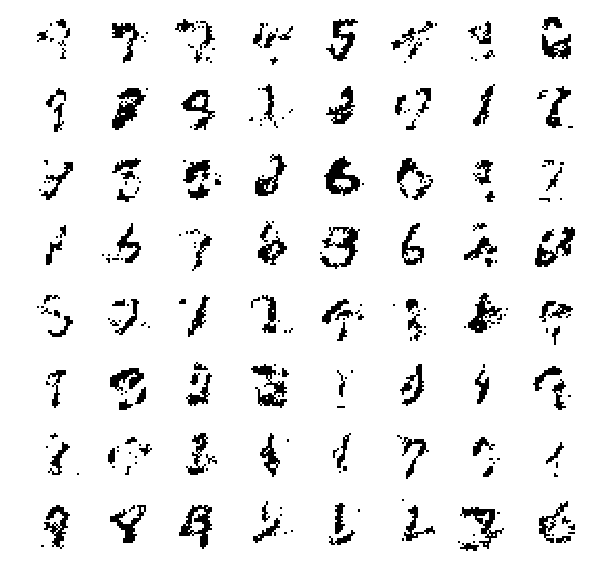

In [5]:
# Generate imgs.
generated = generative_model()
img = sess.run(generated).reshape(-1, 28, 28)
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(img[i], cmap='Greys')
    plt.axis('off')
plt.show()

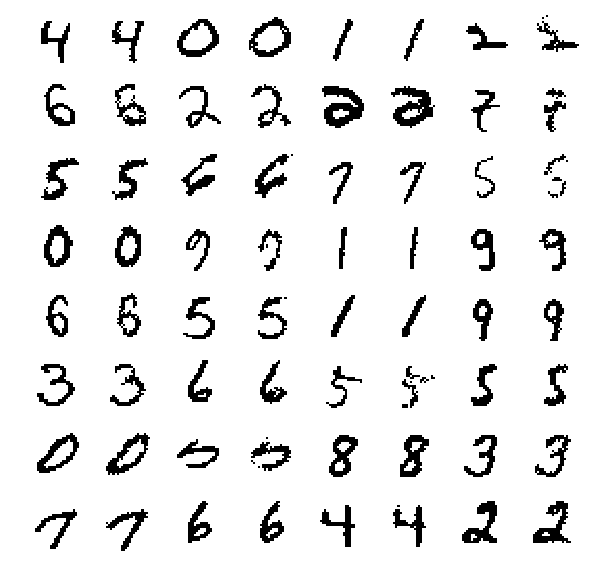

In [6]:
# Reconstruct imgs. Left is original img, right is reconstructed.
batch = batch_x
var_z = variational_model(batch)
with ed.interception(replace_z(z=var_z)):
    recon = generative_model()
sess.run(data_iterator.initializer)
_batch, _recon = sess.run([batch, recon])
_batch, _recon = _batch.reshape(-1, 28, 28), _recon.reshape(-1, 28, 28)
plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(8, 8, 2*i+1)
    plt.imshow(_batch[i], cmap='Greys')
    plt.axis('off')
    plt.subplot(8, 8, 2*i+2)
    plt.imshow(_recon[i], cmap='Greys')
    plt.axis('off')
plt.show()